In [162]:
import os
import re
import json
import glob
import string
import operator
import datetime
from collections import Counter
import itertools
import pandas as pd
import numpy as np
import networkx as nx

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import IPython.display
from IPython.display import display
# plt.rc('font', serif='Times New Roman', family='serif', size=12.0)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Word processing

In [7]:
def readlines_set(filepath):
    return set(line.strip() for line in open(filepath))

stopwords = {
    'postgresql': readlines_set('stopwords/postgresql-english.txt'),
    'nltk': readlines_set('stopwords/nltk-english.txt'),
    'google_1t': readlines_set('stopwords/google-1t.txt'),
    'alphabet': set(string.ascii_lowercase),
    'contraction_suffixes': {'s', 'm', 're', 've', 'll', 'd', 't'},
    'contraction_prefixes': {'don', 'isn'},
}
standard_stopwords_keys = ['google_1t', 'contraction_suffixes', 'contraction_prefixes']
standard_stopwords = set(stopword for key in standard_stopwords_keys for stopword in stopwords[key])
print '|standard_stopwords| =', len(standard_stopwords)

|standard_stopwords| = 202


In [8]:
def tokenize(s, stopwords=None):
    # normalize abbreviations to avoid stranded initials
    s = re.sub(r'(?:[A-Z]\.)+', lambda m: m.group(0).replace('.', ''), s)
    # normalize numbers to avoid 000 turning up as a significant token
    s = re.sub(r',(\d{3})\b', r'\1', s)
    # leave out non-linguistic content
    s = re.sub(r'\[(applause|crosstalk|laughter|inaudible|silence|booing|boos)\]', ' ', s, re.I)
    # replace all non-alphanumerics with spaces
    s = re.sub(r'[^\w]', ' ', s)
    for token in s.lower().strip().split():
        if stopwords is None or token not in stopwords:
            yield token

In [9]:
def speeches_to_counts(speeches, stopwords=None):
    tokens = [token for speech in speeches for token in tokenize(speech['text'], stopwords)]
    return Counter(tokens)

In [10]:
def normalize_counts(counts, smoothing=0.0):
    total = float(sum(counts.values()))
    return {k: (v + smoothing) / total for k, v in counts.items()}

In [11]:
def read_lines(filepaths):
    for filepath in filepaths:
        with open(filepath) as fp:
            for line in fp:
                yield line

In [12]:
def google_1t_frequencies(tokens):
    '''
    Assuming tokens are lower-case.
    '''
    remaining_tokens = set(tokens)
    google_1t_filepath_lower = os.path.expanduser(
        '~/corpora-public/Google-1T-unigrams-only/derivatives/vocab_cs_lower')
    with open(google_1t_filepath_lower) as fp:
        for line in fp:
            token, count_string = line.decode('utf-8').split('\t')
            if token in remaining_tokens:
                remaining_tokens.remove(token)
                yield token, float(count_string) / 1024908267229.0
            if len(remaining_tokens) == 0:
                # exit as soon as we're done
                break

## Speech loading

In [13]:
def read_inaugural():
    for line in read_lines(['../data/tapp/inaugurals.json']):
        yield json.loads(line)

In [14]:
pretrump_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
                                               if 'Trump' not in speech['author'])
print '# tokens:', sum(pretrump_inaugural_counts.values())

# tokens: 134784


In [15]:
# prewar_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
#                                              if speech['timestamp'] < '1948-11-01')
# print '# tokens:', sum(prewar_inaugural_counts.values())

In [16]:
postwar_pretrump_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
                                                       if speech['timestamp'] > '1948-11-01' 
                                                       and 'Trump' not in speech['author'])
print '# tokens:', sum(postwar_pretrump_inaugural_counts.values())
# print 'top 50 types:', postwar_pretrump_inaugural_counts.most_common(50)

# tokens: 33938


In [17]:
def read_election2016_speeches():
    for line in read_lines(['../data/tapp/election2016.json']):
        speech = json.loads(line)
        title = speech['title']
        if 'Press Release' not in title and 'Statement by' not in title:
            yield speech

In [18]:
trump_election2016_counts = speeches_to_counts(speech for speech in read_election2016_speeches()
                                               if speech['author'] == 'Donald J. Trump')
print '# tokens:', sum(trump_election2016_counts.values())
# print 'top 50 types:', trump_election2016_counts.most_common(50)

# tokens: 163319


# Proportion of speech allocated to specific word groups

In [19]:
synsets = [
    ('freedom(s)', ['freedom', 'freedoms']),
    #('justice', ['justice']),
    ('liberty(ies)', ['liberty', 'liberties']),
    #('freedom(s)+\nliberty(ies)', ['freedom', 'freedoms', 'liberty', 'liberties']),
    ('rights', ['rights']),
    #('right(s)', ['right', 'rights']),
    ('america(n(s))', ['america', 'american', 'americans']),
    ('job(s)', ['job', 'jobs']),
    ('peace(ful)', ['peace', 'peaceful']),
    #('constitution', ['constitution']),
    #('principle(s/d)', ['principle', 'principles', 'principled']),
    ('immigrate(ion)', ['immigrate', 'immigrates', 'immigrated', 'immigrating', 'immigration']),
    #('russia/ussr', ['russia', 'ussr']),
    #('china', ['china']),
    ('great(er/est)', ['great', 'greater', 'greatest']),
]

In [20]:
def proportional_usage(tokens, counts):
    maximum = sum(counts.values())
    usage = sum(counts.get(token, 0) for token in tokens)
    return float(usage) / float(maximum)

def synset_proportional_usages(synsets, counts):
    return {synset_name: proportional_usage(synset_tokens, counts) for synset_name, synset_tokens in synsets}

In [21]:
def iter_usages():
    sources = [('All pre-Trump inaugural speeches', pretrump_inaugural_counts),
               #('Pre-war inaugural speeches', prewar_inaugural_counts),
               ('Post-war, pre-Trump inaugural speeches', postwar_pretrump_inaugural_counts),
               ('Trump campaign speeches', trump_election2016_counts)]
    for source_name, source_counts in sources:
        for synset_name, synset_tokens in synsets:
            usage = proportional_usage(synset_tokens, source_counts)
            yield dict(source=source_name, synset=synset_name, usage=usage)

In [22]:
df_usages = pd.DataFrame.from_dict(iter_usages())

In [23]:
df_usages_t = df_usages.pivot(index='synset', columns='source', values='usage')
df_usages_t

source,All pre-Trump inaugural speeches,"Post-war, pre-Trump inaugural speeches",Trump campaign speeches
synset,,,
america(n(s)),0.003146,0.007838,0.010176
freedom(s),0.001417,0.003683,0.000129
great(er/est),0.003175,0.003094,0.002859
immigrate(ion),0.000037,0.000000,0.001194
job(s),0.000096,0.000354,0.004525
liberty(ies),0.001002,0.001355,0.000080
peace(ful),0.002085,0.003182,0.000343
rights,0.001024,0.000648,0.000147


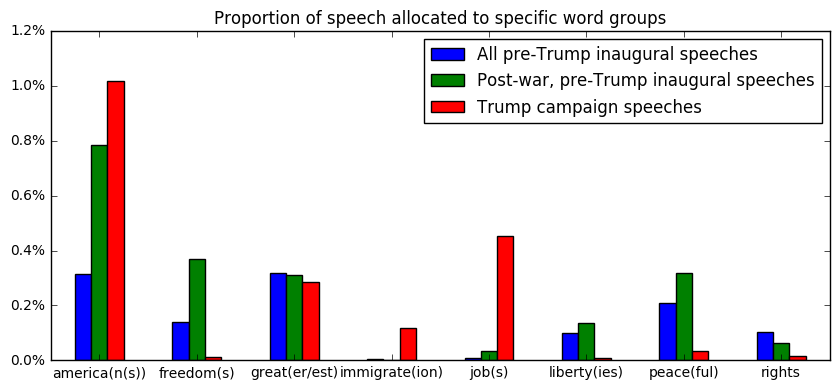

In [24]:
ax = df_usages_t.plot(figsize=(8.5, 4), kind='bar')
ax.xaxis.label.set_visible(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.01%}'.format(y))) 
legend = ax.legend()
legend.set_title(None)
plt.xticks(rotation=0)
plt.title('Proportion of speech allocated to specific word groups')
plt.tight_layout()
# plt.savefig('grouped_proportions.nostopwords.pdf')

# Inaugural address word count

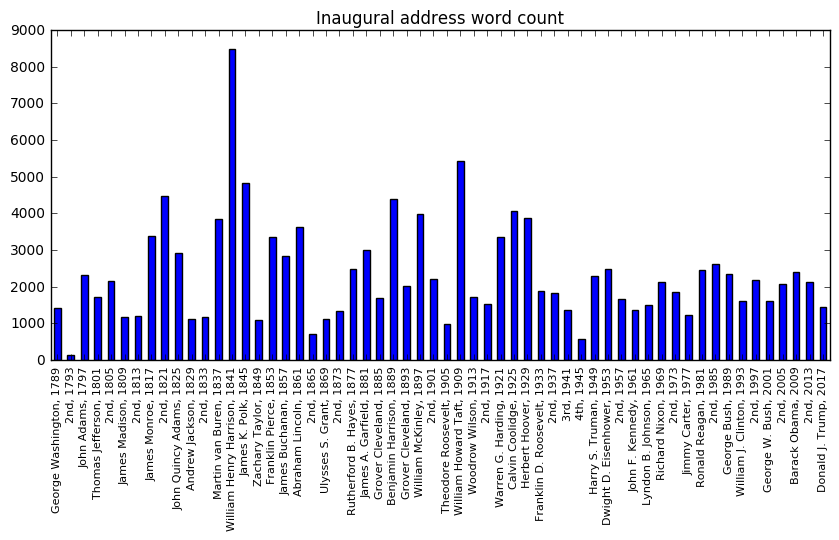

In [34]:
ordinal_mapping = {'First': '1st', 'Second': '2nd', 'Third': '3rd', 'Fourth': '4th'}
def get_inaugural_ticklabels(df):
    last_author = None
    for _, speech in df.iterrows():
        author = speech.author
        title = ordinal_mapping[speech.title.split()[0]] if author == last_author else author
        last_author = author
        yield title + ', ' + str(speech.timestamp.year)
keep_keys = ['title', 'author', 'timestamp']
df = pd.DataFrame.from_dict(dict({key: speech[key] for key in keep_keys}.items() + 
                                 [('word_count', len(list(tokenize(speech['text']))))])
                             for speech in read_inaugural())
df['timestamp'] = pd.to_datetime(df.timestamp)
# draw plot for all inaugurals
ax = df.plot(x='timestamp', y='word_count', figsize=(8.5, 5.5), kind='bar', legend=False, 
             title="Inaugural address word count")
ticklabels = list(get_inaugural_ticklabels(df))
for label in ax.get_xticklabels():
    label.set_fontsize(8)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig('inaugural_word_count.pdf')

# Surname mentions in inaugural speeches

In [35]:
pd.options.display.max_rows = 7
pd.options.display.max_columns = 7

In [36]:
def iter_surnames(speeches, surnames):
    for speech in speeches:
        text = speech['text']
        title = speech['author'] + ': ' + speech['title']
        for surname in surnames:
            surname_count = text.count(surname)
            yield dict(title=title, surname=surname, count=surname_count)

In [39]:
speeches = list(read_inaugural())
surnames_list = [speech['author'].split()[-1] for speech in speeches]
surnames = set(surnames_list)

In [40]:
titles_ordered = [speech['author'] + ': ' + speech['title'] for speech in speeches]
surnames_ordered = sorted(list(surnames), key=surnames_list.index)

In [41]:
df_surnames = pd.DataFrame.from_dict(iter_surnames(speeches, surnames))
df_surnames

,count,surname,title
0,0,Wilson,George Washington: Inaugural Address
1,0,Jackson,George Washington: Inaugural Address
2,0,Buren,George Washington: Inaugural Address
...,...,...,...
2027,0,Truman,Donald J. Trump: Inaugural Address
2028,0,Polk,Donald J. Trump: Inaugural Address
2029,0,Monroe,Donald J. Trump: Inaugural Address


In [42]:
df_xtab = df_surnames.pivot(index='title', columns='surname', values='count')
# reorder columns
df_xtab = df_xtab[surnames_ordered]
# reorder rows
df_xtab = df_xtab.reindex(titles_ordered)
df_xtab

surname,Washington,Adams,Jefferson,...,Clinton,Obama,Trump
title,,,,,,,
George Washington: Inaugural Address,0,0,0,...,0,0,0
George Washington: Second Inaugural Address,0,0,0,...,0,0,0
John Adams: Inaugural Address,0,0,0,...,0,0,0
...,...,...,...,...,...,...,...
Barack Obama: Inaugural Address,0,0,0,...,0,0,0
Barack Obama: Second Inaugural Address,0,0,0,...,0,0,0
Donald J. Trump: Inaugural Address,2,0,0,...,1,3,0


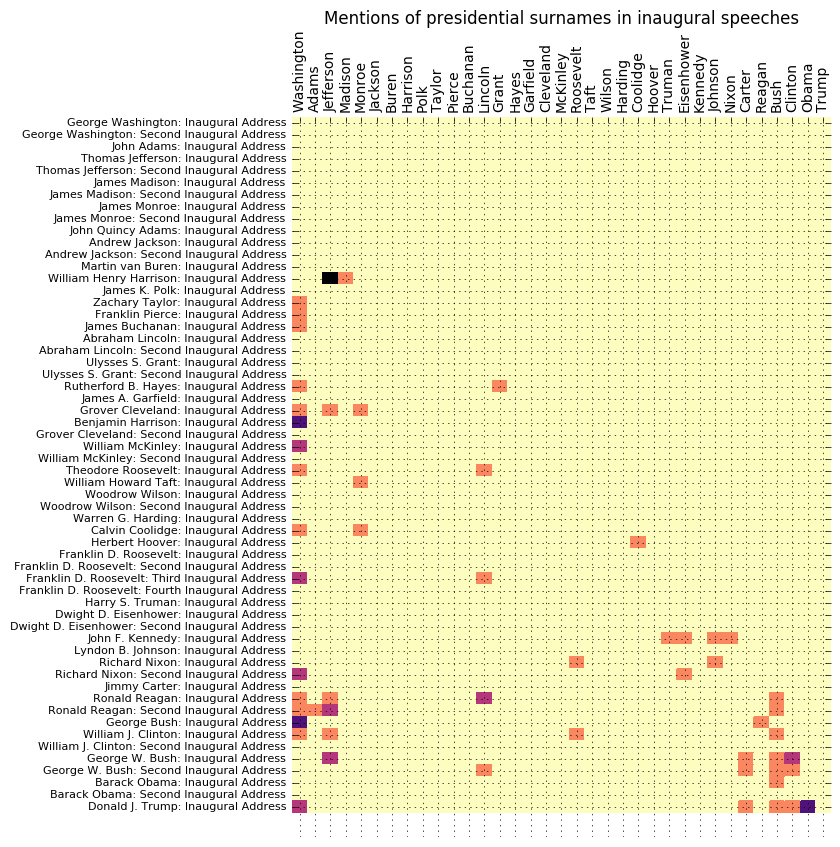

In [43]:
# based on https://stackoverflow.com/a/16124677
plt.figure(figsize=(8.5, 8.5))
plt.pcolor(df_xtab, cmap=plt.cm.magma_r)
ax = plt.axes()
ax.set_frame_on(False)
ax.set_yticks(np.arange(df_xtab.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(df_xtab.shape[1]) + 0.5, minor=False)
# flip x-ticks/labels to top
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
# ax.xaxis.tick_top()
plt.xticks(rotation=90)
# set the x/y tick labels
ax.set_xticklabels(df_xtab.columns, minor=False)
ax.set_yticklabels(df_xtab.index, minor=False)
ax.grid(True)
# better label fit
for label in ax.get_yticklabels():
    label.set_fontsize(8)
plt.title('Mentions of presidential surnames in inaugural speeches', y=1.12)
plt.tight_layout()
# plt.savefig('inaugural_surnames.pdf')

# Self mentions in speeches


# Significant others

In [44]:
def iter_counts(groups, vocab, smoothing=0):
    '''
    groups: a list of (group_name, group_counts) pairs
    vocab: a set/list of tokens
    '''
    for group_name, group_counts in groups:
        for word in vocab:
            yield dict(group=group_name, word=word, word_count=group_counts.get(word, 0) + smoothing)

In [45]:
def set_proportion(df):
    '''
    This seems ugly as the argument to pd.GroupedDataSeries.apply(), but it works
    '''
    df['proportion'] = df['word_count'] / np.sum(df['word_count'])
    return df

In [46]:
pd.options.display.max_columns = 10
pd.options.display.max_rows = 10

In [101]:
# postwar pre-trump
# inaugural_counts = speeches_to_counts(
#     (speech for speech in read_inaugural() 
#      if speech['timestamp'] > '1948-11-01' 
#      and 'Trump' not in speech['author']), standard_stopwords)
# all pre-trump
inaugural_counts = speeches_to_counts(
    (speech for speech in read_inaugural() 
     if 'Trump' not in speech['author']), standard_stopwords)
print '|inaugural_counts| =', sum(inaugural_counts.values())

|inaugural_counts| = 58308


In [102]:
trump_election2016_counts = speeches_to_counts(
    (speech for speech in read_election2016_speeches()
     if speech['author'] == 'Donald J. Trump'), standard_stopwords)
print '|tokens| =', sum(trump_election2016_counts.values())

|tokens| = 73304


In [103]:
groups = [('inaugural', inaugural_counts),
          ('trump', trump_election2016_counts)]

In [104]:
full_vocab = set([token for _, counts in groups for token in counts.keys()]) # 12219
print '|full_vocab| =', len(full_vocab)

|full_vocab| = 12272


In [105]:
k = 250
smoothing = 1.0

In [106]:
df_counts = pd.DataFrame.from_dict(iter_counts(groups, full_vocab, smoothing)).groupby('group').apply(set_proportion)
# df_counts

In [107]:
# derive more condensed vocabulary
df_proportions_merged = df_counts.groupby('word').agg({'proportion': sum})
# df_proportions_merged.sort_values('proportion', ascending=False)

In [108]:
vocab = set(df_proportions_merged.nlargest(k, 'proportion').index)
print '|vocab| =', len(vocab)

|vocab| = 250


In [109]:
print ' '.join(vocab)

remember office less money executive years bring including human love children increase thank justice workers percent education crime better failed win policy tell women thousands strength hope build pay family good government far big safe stop nation cannot know words communities world trade emails nor school necessary like lost countries schools always seek taxes across deals bad common small done security secretary right old deal people doing national principles past donald economic election year happen ourselves best large said constitution federal god radical liberty business state energy safety obamacare between progress public themselves cost million jobs power whose men free job china others ask cities respect change care faith great defense working freedom dollars citizens days against foreign american place stand action military poverty whole think first duty clinton secure campaign civil political washington number community two down massive americans another vote force open

In [110]:
# could take a second depending on how rare the vocab is
# vocab_1t_frequencies = dict(google_1t_frequencies(vocab))

In [111]:
# recount with condensed vocab
df_counts = pd.DataFrame.from_dict(iter_counts(groups, vocab, smoothing)).groupby('group').apply(set_proportion)
# df_counts.sort_values('proportion', ascending=False)

### Oh boy word clouds

In [58]:
from wordcloud import WordCloud

In [59]:
def display_frequencies_wordcloud(frequencies):
    #wordCloud = WordCloud(max_font_size=40)
    wordCloud = WordCloud()
    wordCloud_generated = wordCloud.generate_from_frequencies(frequencies)
    plt.imshow(wordCloud_generated)
    plt.axis('off')

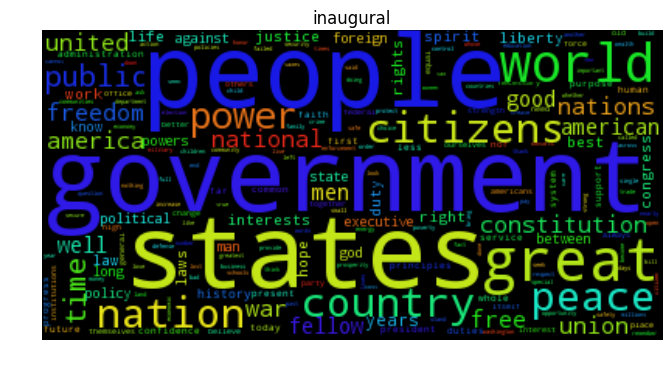

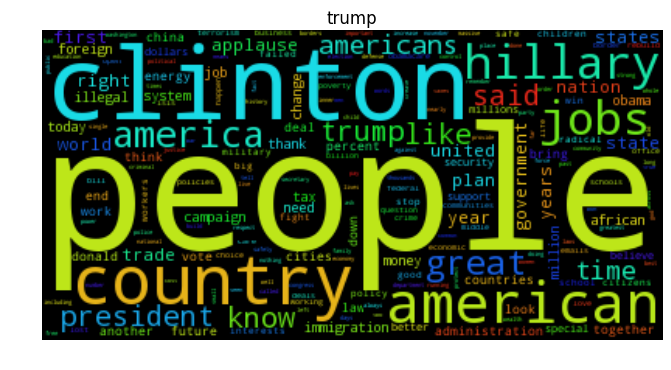

In [60]:
for group, group_df in df_counts.groupby('group'):
    plt.figure(figsize=(8.5, 4))
    display_frequencies_wordcloud(zip(group_df.word, group_df.proportion))    
    plt.title(group)

### Back to business

That's nice to look at, but we also want some consistent ordering of relative inaugural-ness vs. Trumpery.

We can get that just by dividing one over the other. We'll use Trump proportion / Inaugural proportion, so higher values will indicate higher Trumpery.

In [112]:
df_proportions = df_counts.pivot(index='word', columns='group', values='proportion')
df_proportions['trump/inaugural'] = df_proportions.trump / df_proportions.inaugural

The ratio produces the desired ordering, but it ranges from very tiny values,
to 1 (meaning similar usage), to arbitrarily large values.

As we'll seen in a second with the (log-log) scatter plot, what we want is a sort of radial / angular measure.
The words around the y=x diagonal see similar usage, with the words in the upper-left being more Trump-ish and the words in the lower-right being more Inaugural.
Yay trigonometry!

In [117]:
#rad = np.arctan(df_proportions['trump/inaugural'])
rad = np.arctan2(df_proportions.trump, df_proportions.inaugural)
# re-map from [0, pi/2] to [-1, 1]
df_proportions[u'trump°inaugural'] = rad * (4.0 / np.pi) + -1.0

In [118]:
df_proportions = df_proportions.sort_values(u'trump°inaugural')

In [114]:
# df_proportions['google_1t'] = df_proportions.index.map(lambda k: vocab_1t_frequencies.get(k, 1))

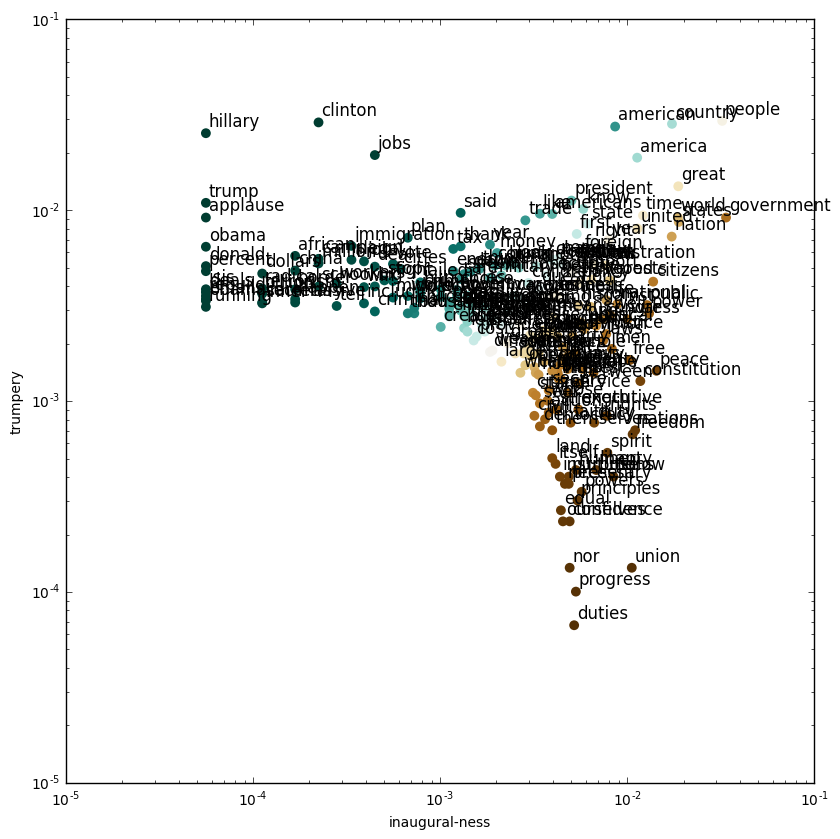

In [115]:
plt.figure(figsize=(8.5, 8.5))
# x
x = df_proportions['inaugural']
plt.xscale('log')
# plt.xlabel('global frequency of word (based on Google 1T unigrams)')
plt.xlabel('inaugural-ness')
# y
y = df_proportions['trump']
plt.yscale('log')
# plt.ylabel(u'relative\n<- inauguralness or Trumpery ->')
plt.ylabel('trumpery')
# points
plt.scatter(x, y, c=df_proportions[u'trump°inaugural'], cmap=plt.cm.BrBG, linewidths=0, s=50)
for label, x, y in zip(df_proportions.index, x, y):
    plt.annotate(label, xy=(x, y), xytext=(2, 2),
                 size='large',
                 textcoords='offset points', ha='left', va='bottom')
plt.tight_layout()

That's neat, but kind of a mess. More directly, we can look at the actual ranking.

In [119]:
pd.options.display.max_rows = 20
df_proportions

group,inaugural,trump,trump/inaugural,trump°inaugural
word,,,,
union,0.010576,0.000134,0.012665,-0.983876
duties,0.005204,0.000067,0.012869,-0.983616
progress,0.005316,0.000100,0.018897,-0.975943
nor,0.004924,0.000134,0.027200,-0.965376
fellow,0.008450,0.000402,0.047555,-0.939497
confidence,0.004924,0.000234,0.047600,-0.939440
ourselves,0.004533,0.000234,0.051714,-0.934215
principles,0.005428,0.000301,0.055522,-0.929380
powers,0.005708,0.000335,0.058667,-0.925389


Still, it's a lot of numbers. Let's discretize.

### Categories of trumpiness 

Having an ordering on the words means we can bin the words in discrete chunks.

The `trump/inaugural` ratio is monotonic with the `trump°inaugural` column, but since the latter has a nicer scale, we'll use it.

In [123]:
# equal bin widths:
# _, binedges = np.histogram(df_proportions[u'trump°inaugural'], bins=7)
# equal bin depths:
binedges = np.percentile(df_proportions[u'trump°inaugural'], np.linspace(0, 100, 8))

In [124]:
binnames = ['Most presidential', '2nd-most presidential', '3rd-most presidential',
            'Neutral', 
            '3rd-most Trumpy', '2nd-most Trumpy', 'Most Trumpy']
assignments = np.digitize(df_proportions[u'trump°inaugural'], binedges[:-1]) - 1
df_proportions['trumpiness'] = np.array(binnames)[assignments]

In [125]:
trumpiness_bins = [(name, pd.Series(list(group_df.sort_values(u'trump°inaugural', ascending=True).word)))
                   for name, group_df in df_proportions.reset_index().groupby('trumpiness')]
df_bins = pd.DataFrame(dict(trumpiness_bins)).fillna('')
df_bins = df_bins[binnames]

In [126]:
pd.options.display.max_rows = 40
df_bins

,Most presidential,2nd-most presidential,3rd-most presidential,Neutral,3rd-most Trumpy,2nd-most Trumpy,Most Trumpy
0,union,action,life,federal,first,doing,win
1,duties,service,true,greatest,children,like,plan
2,progress,public,long,years,single,taxes,tell
3,nor,man,states,people,care,poverty,deal
4,fellow,civil,become,support,community,money,job
5,confidence,war,against,business,seen,open,workers
6,ourselves,whose,world,lives,election,think,illegal
7,principles,government,old,wealth,another,trade,school
8,powers,laws,whether,times,country,choice,immigration
9,equal,seek,respect,different,education,american,massive


# Focus

How about we focus in on a couple specific words.

In [139]:
ranked_words = list(df_proportions.sort_values(u'trump°inaugural').index)
inaugural_20 = ranked_words[:20]
print 'inaugural_20:', ', '.join(inaugural_20)
trump_20 = ranked_words[-20:]
print 'trump_20:', ', '.join(trump_20)

inaugural_20: union, duties, progress, nor, fellow, confidence, ourselves, principles, powers, equal, freedom, liberty, nations, spirit, present, necessary, human, purpose, institutions, peace
trump_20: secretary, billion, terrorism, african, radical, dollars, jobs, running, obamacare, emails, rebuild, deals, isis, percent, donald, obama, clinton, applause, trump, hillary


In [163]:
extreme_40 = set(trump_20 + inaugural_20)

In [191]:
keywords = {'freedom', 'freedoms', 'liberty', 'liberties', 'rights'}

In [192]:
from adjustText import adjust_text

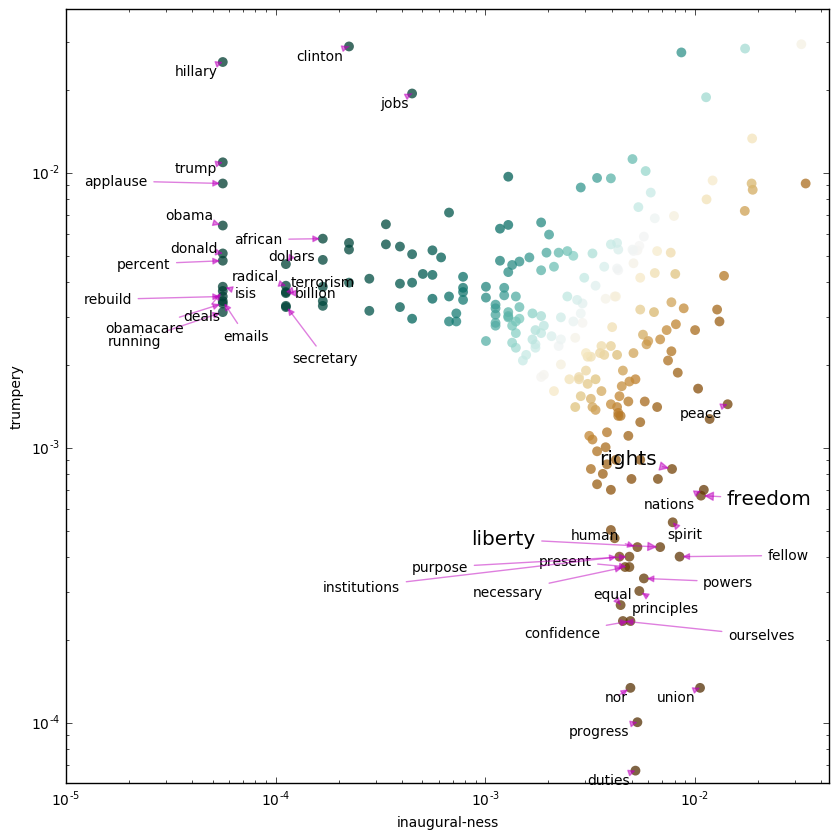

In [197]:
plt.figure(figsize=(8.5, 8.5))
plt.xscale('log')
plt.xlabel('inaugural-ness')
plt.yscale('log')
plt.ylabel('trumpery')
# points
plt.scatter(df_proportions.inaugural, df_proportions.trump,
            c=df_proportions[u'trump°inaugural'], cmap=plt.cm.BrBG, linewidths=0, s=50, alpha=0.75)
# labels
annotations = []
for label, x, y in zip(df_proportions.index, df_proportions.inaugural, df_proportions.trump):
    if label in (extreme_40 | keywords):
        size = 'x-large' if label in keywords else None
        annotation = plt.text(x, y, label, size=size)
        annotations.append(annotation)
# adjustments
adjust_text(annotations, force_text=0.1, arrowprops=dict(arrowstyle="-|>", color='m', alpha=0.5))
plt.xlim(plt.xlim()[0], max(df_proportions.inaugural) + .01)
plt.ylim(min(df_proportions.trump) - .2, max(df_proportions.trump) + .01)
plt.tight_layout()
# plt.savefig('relative_trumpery_scatter_100-40labeled.pdf')